# 🌿 Baseline MS (Multispectral) - ResNet18
## Beyond Visible Spectrum: AI for Agriculture 2026

**Multispectral Bands:**
- Band 0: Blue
- Band 1: Green
- Band 2: Red
- Band 3: Red-edge
- Band 4: Near Infrared (NIR)

**Pipeline:**
1. EDA & Data Loading
2. Dataset & DataLoader (5 channels)
3. Model: ResNet18 modified for 5 channels
4. Training với WandB logging
5. Evaluation & Confusion Matrix
6. Inference & Submission

## 1. Imports & Config

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import wandb

# Config
CONFIG = {
    "seed": 42,
    "img_size": 64,
    "batch_size": 32,
    "epochs": 10,
    "lr": 1e-4,
    "val_split": 0.2,
    "num_classes": 3,
    "in_channels": 5,  # MS có 5 bands
    "model_name": "resnet18",
}

# Paths - LOCAL
TRAIN_MS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\Kaggle_Prepared\train\MS"
TEST_MS_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\data\raw\Kaggle_Prepared\val\MS"
CHECKPOINT_DIR = r"D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints"

# # Paths - KAGGLE
# TRAIN_MS_DIR = "/kaggle/input/beyond-visible-spectrum/train/MS"
# TEST_MS_DIR = "/kaggle/input/beyond-visible-spectrum/test/MS"
# CHECKPOINT_DIR = "/kaggle/working"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Set seed
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(CONFIG["seed"])

Device: cuda


## 2. EDA - Exploratory Data Analysis

Total images: 600
Classes: {'Health': 200, 'Other': 200, 'Rust': 200}


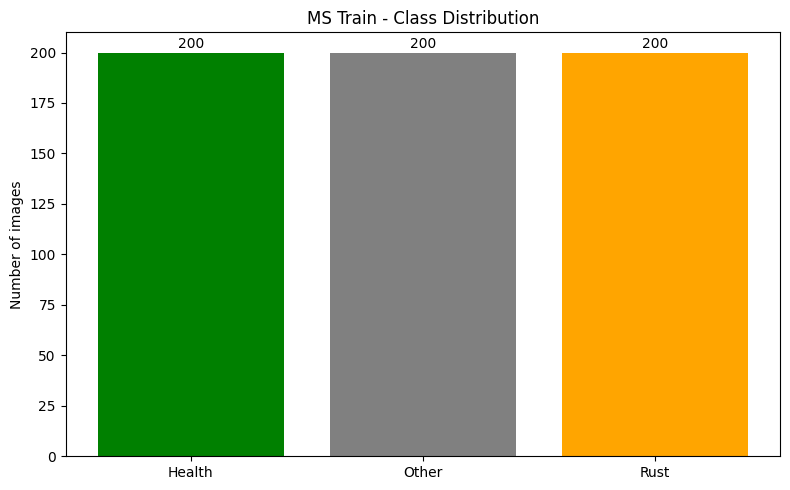

In [10]:
def label_from_filename(fname: str) -> str:
    """Extract label from filename: 'Rust_hyper_184.tif' -> 'Rust'"""
    return os.path.basename(fname).split("_")[0]

# Count images per class
files = [f for f in os.listdir(TRAIN_MS_DIR) if f.lower().endswith((".tif", ".tiff"))]
class_counts = Counter(label_from_filename(f) for f in files)

print(f"Total images: {len(files)}")
print(f"Classes: {dict(class_counts)}")

# Plot distribution
plt.figure(figsize=(8, 5))
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]
plt.bar(classes, counts, color=['green', 'gray', 'orange'])
plt.ylabel('Number of images')
plt.title('MS Train - Class Distribution')
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha='center')
plt.tight_layout()
plt.show()

In [11]:
# Explore MS image properties
sample_file = files[0]
sample_path = os.path.join(TRAIN_MS_DIR, sample_file)
arr = tiff.imread(sample_path)

print(f"File: {sample_file}")
print(f"Original shape: {arr.shape}")
print(f"Dtype: {arr.dtype}")
print(f"Min/Max: {arr.min()} / {arr.max()}")

# Normalize shape to (H, W, C)
if arr.ndim == 3 and arr.shape[0] < 20 and arr.shape[0] != arr.shape[-1]:
    arr = np.transpose(arr, (1, 2, 0))
    print(f"Transposed shape: {arr.shape}")

H, W, C = arr.shape
print(f"\nImage size: {H}x{W}")
print(f"Number of bands: {C}")

File: Health_hyper_1.tif
Original shape: (64, 64, 5)
Dtype: uint16
Min/Max: 272 / 4936

Image size: 64x64
Number of bands: 5


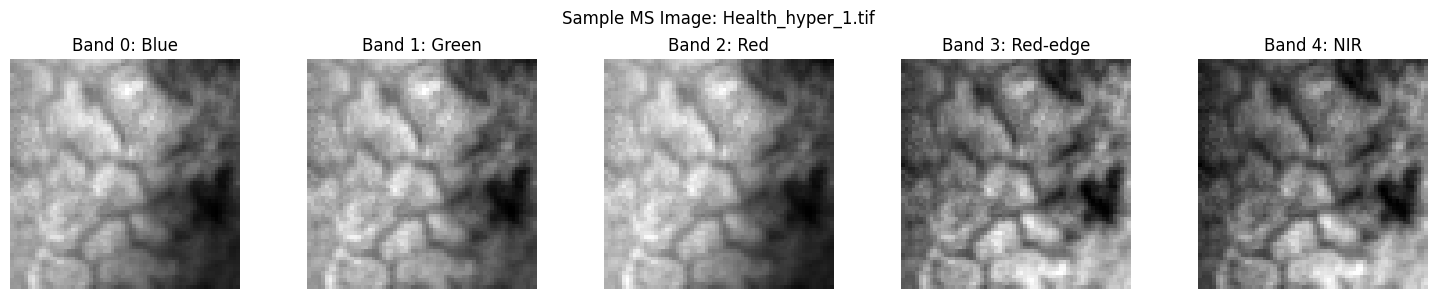

In [12]:
# Visualize all 5 bands
band_names = ["Blue", "Green", "Red", "Red-edge", "NIR"]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for b in range(C):
    band = arr[:, :, b]
    axes[b].imshow(band, cmap='gray')
    axes[b].set_title(f"Band {b}: {band_names[b]}")
    axes[b].axis('off')

plt.suptitle(f"Sample MS Image: {sample_file}")
plt.tight_layout()
plt.show()

In [13]:
# # Band histogram per class
# band_stats = defaultdict(lambda: {"sum": 0.0, "sq": 0.0, "n": 0})

# for f in files[:100]:  # Sample 100 files for speed
#     label = label_from_filename(f)
#     arr = tiff.imread(os.path.join(TRAIN_MS_DIR, f))
    
#     if arr.ndim == 3 and arr.shape[0] < 20 and arr.shape[0] != arr.shape[-1]:
#         arr = np.transpose(arr, (1, 2, 0))
    
#     arr = arr.astype(np.float32)
#     arr = arr / (arr.max() + 1e-8)
    
#     for b in range(arr.shape[2]):
#         band = arr[:, :, b]
#         band_stats[(label, b)]["sum"] += band.mean()
#         band_stats[(label, b)]["sq"] += band.std()
#         band_stats[(label, b)]["n"] += 1

# # Print stats
# labels = sorted(set(label_from_filename(f) for f in files))
# print("Band Statistics by Class:")
# print("=" * 50)

# for b in range(5):
#     print(f"\nBand {b} ({band_names[b]}):")
#     for lbl in labels:
#         s = band_stats[(lbl, b)]
#         if s["n"] > 0:
#             mean = s["sum"] / s["n"]
#             std = s["sq"] / s["n"]
#             print(f"  {lbl:8s} | mean={mean:.4f}  std={std:.4f}")

In [14]:
import tifffile as tiff
from tqdm import tqdm

def compute_global_stats(img_dir):
    print("Computing global stats...")
    files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.tif', '.tiff'))]
    
    # Khởi tạo s1 (tổng) và s2 (tổng bình phương) cho 5 kênh
    channels = 5
    pixel_num = 0 # Tổng số pixel đã duyệt
    channel_sum = np.zeros(channels)
    channel_sum_sq = np.zeros(channels) 

    for f in tqdm(files):
        path = os.path.join(img_dir, f)
        img = tiff.imread(path).astype(np.float32)
        
        # Xử lý shape (H, W, C)
        if img.ndim == 3 and img.shape[0] == 5: # Nếu là (C, H, W)
            img = np.transpose(img, (1, 2, 0))
            
        # Normalize sơ bộ về khoảng [0, 1] dựa trên bit-depth (uint16)
        # Giá trị max của uint16 là 65535, nhưng dữ liệu vệ tinh thường chỉ dùng ~10000-20000.
        # Ở đây ta giữ nguyên giá trị raw hoặc chia cho 1 hằng số cố định (ví dụ 65535) nếu muốn.
        # Tốt nhất là tính trên giá trị Raw để chính xác nhất.
        
        # Reshape thành (N, C) để tính toán dễ hơn
        pixels = img.reshape(-1, channels)
        
        channel_sum += pixels.sum(axis=0)
        channel_sum_sq += (pixels ** 2).sum(axis=0)
        pixel_num += pixels.shape[0]
    
    # Tính mean và std
    mean = channel_sum / pixel_num
    std = np.sqrt(channel_sum_sq / pixel_num - mean ** 2)
    
    return mean, std

# Chạy hàm này trên tập TRAIN
# mean, std = compute_global_stats(TRAIN_MS_DIR)
# print(f"Mean: {mean}")
# print(f"Std: {std}")

## 3. Dataset & DataLoader

In [15]:
import tifffile as tiff
from tqdm import tqdm

def compute_global_stats(img_dir):
    print("Computing global stats (Mean & Std)...")
    files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.tif', '.tiff'))]
    
    channels = 5
    pixel_num = 0
    channel_sum = np.zeros(channels)
    channel_sum_sq = np.zeros(channels) 

    for f in tqdm(files):
        path = os.path.join(img_dir, f)
        img = tiff.imread(path).astype(np.float32)
        
        # Handle shape (H, W, C)
        if img.ndim == 3 and img.shape[0] == 5 and img.shape[-1] != 5:
            img = np.transpose(img, (1, 2, 0))
            
        # Normalize to [0, 1] range (assuming 16-bit input)
        img = img / 65535.0
        
        pixels = img.reshape(-1, channels)
        
        channel_sum += pixels.sum(axis=0)
        channel_sum_sq += (pixels ** 2).sum(axis=0)
        pixel_num += pixels.shape[0]
    
    mean = channel_sum / pixel_num
    std = np.sqrt(channel_sum_sq / pixel_num - mean ** 2)
    
    print(f"Global Mean: {mean}")
    print(f"Global Std:  {std}")
    return mean, std

class MSDataset(Dataset):
    """Multispectral Image Dataset - loads TIFF images with 5 bands"""
    
    def __init__(self, img_dir, file_list=None, img_size=64, augment=False, mean=None, std=None):
        self.img_dir = img_dir
        self.img_size = img_size
        self.augment = augment
        
        # Store global stats for normalization
        self.mean = torch.tensor(mean).view(5, 1, 1).float() if mean is not None else torch.zeros(5, 1, 1)
        self.std = torch.tensor(std).view(5, 1, 1).float() if std is not None else torch.ones(5, 1, 1)
        
        if file_list is not None:
            self.files = file_list
        else:
            self.files = sorted([f for f in os.listdir(img_dir) 
                                if f.lower().endswith((".tif", ".tiff"))])
        
        # Create label mapping
        labels = sorted({label_from_filename(f) for f in self.files})
        self.class_to_idx = {c: i for i, c in enumerate(labels)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}
        self.y = [self.class_to_idx[label_from_filename(f)] for f in self.files]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        label = self.y[idx]
        
        # Load TIFF
        path = os.path.join(self.img_dir, fname)
        arr = tiff.imread(path)
        
        # Normalize shape to (H, W, C)
        if arr.ndim == 2:
            arr = arr[..., None]
        elif arr.ndim == 3 and arr.shape[0] == 5 and arr.shape[-1] != 5:
            arr = np.transpose(arr, (1, 2, 0))
        
        # Convert to float32 and scale to [0, 1] using fixed constant
        arr = arr.astype(np.float32)
        arr = arr / 65535.0
        
        # Convert to tensor (C, H, W)
        x = torch.from_numpy(arr).permute(2, 0, 1)
        
        # Z-score Normalization (Global standardization)
        x = (x - self.mean) / (self.std + 1e-8)
        
        # Resize
        x = x.unsqueeze(0)
        x = F.interpolate(x, size=(self.img_size, self.img_size), 
                         mode="bilinear", align_corners=False)
        x = x.squeeze(0)
        
        # Augmentation (for training)
        if self.augment:
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[2])
            # Random vertical flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[1])
            # Random 90 degree rotation
            k = torch.randint(0, 4, (1,)).item()
            x = torch.rot90(x, k, dims=[1, 2])
        
        return x, label


class MSTestDataset(Dataset):
    """MS Test Dataset - returns image and filename (no label)"""
    
    def __init__(self, img_dir, img_size=64, mean=None, std=None):
        self.img_dir = img_dir
        self.img_size = img_size
        self.mean = torch.tensor(mean).view(5, 1, 1).float() if mean is not None else torch.zeros(5, 1, 1)
        self.std = torch.tensor(std).view(5, 1, 1).float() if std is not None else torch.ones(5, 1, 1)
        
        self.files = sorted([f for f in os.listdir(img_dir) 
                            if f.lower().endswith((".tif", ".tiff"))])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.img_dir, fname)
        arr = tiff.imread(path)
        
        # Normalize shape
        if arr.ndim == 2:
            arr = arr[..., None]
        elif arr.ndim == 3 and arr.shape[0] == 5 and arr.shape[-1] != 5:
            arr = np.transpose(arr, (1, 2, 0))
        
        arr = arr.astype(np.float32)
        arr = arr / 65535.0
        
        x = torch.from_numpy(arr).permute(2, 0, 1)
        x = (x - self.mean) / (self.std + 1e-8)
        
        x = x.unsqueeze(0)
        x = F.interpolate(x, size=(self.img_size, self.img_size), 
                         mode="bilinear", align_corners=False)
        x = x.squeeze(0)
        
        return x, fname


In [16]:
# Compute global statistics first
mean_stats, std_stats = compute_global_stats(TRAIN_MS_DIR)

# Split train/val using a temp dataset with default args to get file list
base_ds = MSDataset(TRAIN_MS_DIR, img_size=CONFIG["img_size"], augment=False, mean=mean_stats, std=std_stats)
indices = np.arange(len(base_ds))
train_idx, val_idx = train_test_split(
    indices, 
    test_size=CONFIG["val_split"], 
    random_state=CONFIG["seed"], 
    stratify=base_ds.y
)

# Create file lists
train_files = [base_ds.files[i] for i in train_idx]
val_files = [base_ds.files[i] for i in val_idx]

# Create datasets with Proper Normalization
train_ds = MSDataset(TRAIN_MS_DIR, file_list=train_files, 
                     img_size=CONFIG["img_size"], augment=True, 
                     mean=mean_stats, std=std_stats)
val_ds = MSDataset(TRAIN_MS_DIR, file_list=val_files, 
                   img_size=CONFIG["img_size"], augment=False,
                   mean=mean_stats, std=std_stats)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], 
                         shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"], 
                       shuffle=False, num_workers=0)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Classes: {train_ds.class_to_idx}")

# Verify shapes
x, y = next(iter(train_loader))
print(f"\nBatch shape: {x.shape}")


Computing global stats (Mean & Std)...


100%|██████████| 600/600 [00:06<00:00, 94.41it/s] 


Global Mean: [0.00629888 0.01161091 0.01213666 0.03333251 0.04109975]
Global Std:  [0.00576518 0.00716039 0.01015545 0.01309597 0.01721159]
Train samples: 480
Val samples: 120
Classes: {'Health': 0, 'Other': 1, 'Rust': 2}

Batch shape: torch.Size([32, 5, 64, 64])


## 4. Model Definition

In [17]:
def create_ms_model(in_channels, num_classes, pretrained=True):
    """
    Create ResNet18 model modified for multispectral input (5 channels)
    
    Strategy: Initialize first conv layer to accept 5 channels by
    averaging the pretrained RGB weights and replicating.
    """
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    else:
        model = models.resnet18(weights=None)
    
    # Save original conv1
    old_conv = model.conv1
    
    # Create new conv1 for 5 channels
    model.conv1 = nn.Conv2d(
        in_channels, 
        old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        bias=False
    )
    
    # Initialize with averaged pretrained weights
    if pretrained:
        with torch.no_grad():
            # Average RGB weights → neutral kernel
            w_avg = old_conv.weight.mean(dim=1, keepdim=True)  # (64, 1, 7, 7)
            # Replicate for all 5 channels
            model.conv1.weight.copy_(w_avg.repeat(1, in_channels, 1, 1))
    
    # Replace final FC layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model


model = create_ms_model(
    in_channels=CONFIG["in_channels"],
    num_classes=CONFIG["num_classes"],
    pretrained=True
)
model = model.to(device)

print(f"Model: {CONFIG['model_name']} (modified for {CONFIG['in_channels']} channels)")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Verify forward pass
with torch.no_grad():
    dummy = torch.randn(2, 5, 64, 64).to(device)
    out = model(dummy)
    print(f"Output shape: {out.shape}  (expected: [2, {CONFIG['num_classes']}])")

Model: resnet18 (modified for 5 channels)
Parameters: 11,184,323
Output shape: torch.Size([2, 3])  (expected: [2, 3])


## 5. Training

In [18]:
def train_one_epoch(model, loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model"""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / total, correct / total

In [20]:
# Initialize WandB
wandb.init(
    project="beyond-visible-spectrum",
    name=f"baseline_ms_{CONFIG['model_name']}",
    config=CONFIG
)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["lr"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

# Training loop
best_val_acc = 0.0
best_model_path = os.path.join(CHECKPOINT_DIR, "best_ms_resnet18.pth")

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, CONFIG["epochs"] + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    # Scheduler step
    scheduler.step(val_acc)
    
    # Log to WandB
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "lr": optimizer.param_groups[0]['lr']
    })
    
    # Save history
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} ⭐ BEST")
    else:
        print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f}")

wandb.finish()
print(f"\n✓ Best val_acc: {best_val_acc:.4f}")
print(f"✓ Model saved to: {best_model_path}")

wandb: Currently logged in as: phucga150625 (phucga15062005) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 01 | train_acc=0.4750 val_acc=0.5167 ⭐ BEST
Epoch 02 | train_acc=0.6125 val_acc=0.4833
Epoch 03 | train_acc=0.6375 val_acc=0.5333 ⭐ BEST
Epoch 04 | train_acc=0.7000 val_acc=0.5833 ⭐ BEST
Epoch 05 | train_acc=0.6854 val_acc=0.5917 ⭐ BEST
Epoch 06 | train_acc=0.7479 val_acc=0.5667
Epoch 07 | train_acc=0.7417 val_acc=0.5167
Epoch 08 | train_acc=0.7812 val_acc=0.5917
Epoch 09 | train_acc=0.7917 val_acc=0.5833
Epoch 10 | train_acc=0.8313 val_acc=0.5917


epoch,▁▂▃▃▄▅▆▆▇█
lr,████████▁▁
train_acc,▁▄▄▅▅▆▆▇▇█
train_loss,█▆▄▄▄▂▂▂▂▁
val_acc,▃▁▄▇█▆▃█▇█
val_loss,██▄▂▁▃▂▁▁▄
epoch,10
lr,5e-05
train_acc,0.83125
train_loss,0.44097
val_acc,0.59167



✓ Best val_acc: 0.5917
✓ Model saved to: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\best_ms_resnet18.pth


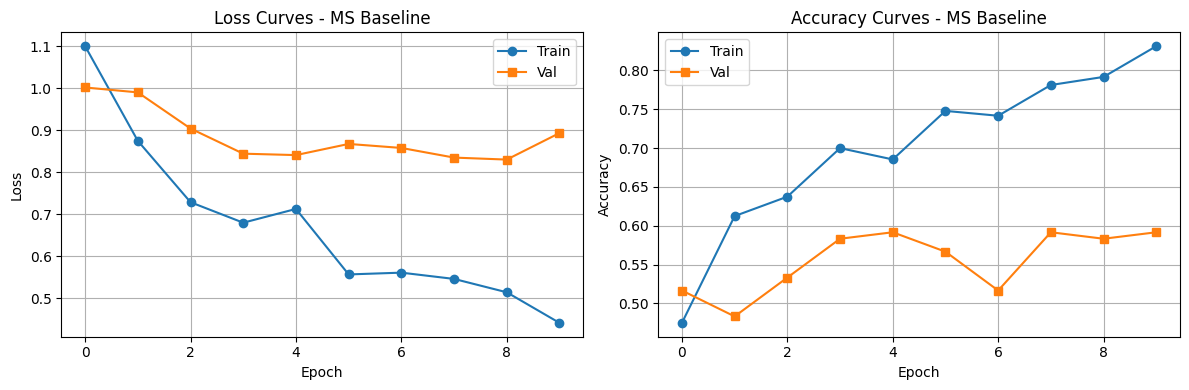

In [21]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], label="Train", marker='o')
axes[0].plot(history["val_loss"], label="Val", marker='s')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curves - MS Baseline")
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history["train_acc"], label="Train", marker='o')
axes[1].plot(history["val_acc"], label="Val", marker='s')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curves - MS Baseline")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 6. Evaluation

In [22]:
# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Get predictions on validation set
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
class_names = [val_ds.idx_to_class[i] for i in range(CONFIG["num_classes"])]
print("Classification Report (MS Baseline):")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report (MS Baseline):
              precision    recall  f1-score   support

      Health       0.48      0.50      0.49        40
       Other       0.85      0.70      0.77        40
        Rust       0.51      0.57      0.54        40

    accuracy                           0.59       120
   macro avg       0.61      0.59      0.60       120
weighted avg       0.61      0.59      0.60       120



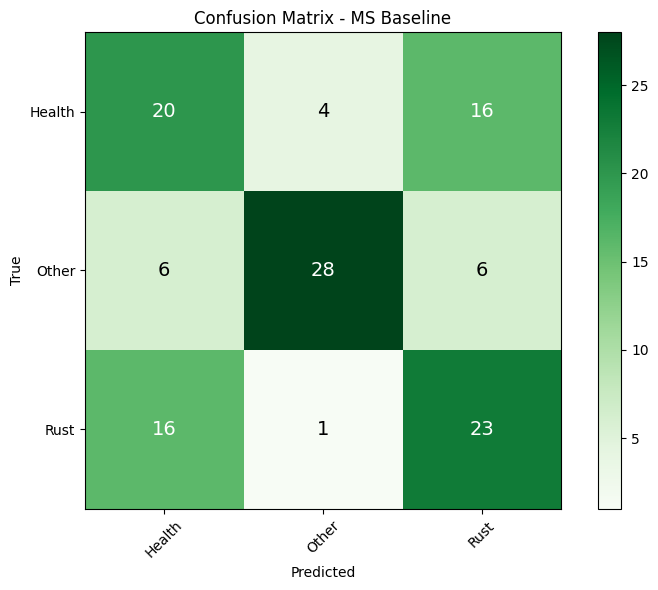

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix - MS Baseline")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## 7. Inference & Submission

In [24]:
# Check if test directory exists
if os.path.exists(TEST_MS_DIR):
    # Note: Using stats computed during training
    test_ds = MSTestDataset(TEST_MS_DIR, img_size=CONFIG["img_size"], mean=mean_stats, std=std_stats)
    test_loader = DataLoader(test_ds, batch_size=CONFIG["batch_size"], 
                            shuffle=False, num_workers=0)
    print(f"Test samples: {len(test_ds)}")
else:
    print(f"⚠️ Test directory not found: {TEST_MS_DIR}")
    print("Skipping test inference...")


Test samples: 300


In [25]:
# Run inference on test set
if os.path.exists(TEST_MS_DIR):
    model.eval()
    predictions = []
    filenames = []
    
    idx_to_class = val_ds.idx_to_class
    
    with torch.no_grad():
        for images, fnames in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            # Convert to class names
            pred_labels = [idx_to_class[p] for p in preds]
            
            predictions.extend(pred_labels)
            filenames.extend(fnames)
    
    print(f"✓ Predicted {len(predictions)} test samples")
    print(f"Sample predictions: {list(zip(filenames[:5], predictions[:5]))}")

✓ Predicted 300 test samples
Sample predictions: [('val_000a83c1.tif', 'Health'), ('val_00a704b1.tif', 'Health'), ('val_01dde030.tif', 'Rust'), ('val_024df365.tif', 'Rust'), ('val_02afcb0e.tif', 'Health')]


In [26]:
# Create submission CSV
import pandas as pd

if os.path.exists(TEST_MS_DIR):
    submission_df = pd.DataFrame({
        'ID': filenames,
        'label': predictions
    })
    
    # Sort by filename
    submission_df = submission_df.sort_values('ID').reset_index(drop=True)
    
    # Save
    submission_path = os.path.join(CHECKPOINT_DIR, "submission_ms.csv")
    submission_df.to_csv(submission_path, index=False)
    
    print(f"✓ Saved submission to: {submission_path}")
    print(f"✓ Total predictions: {len(submission_df)}")
    print(f"\nFirst 10 rows:")
    print(submission_df.head(10))
    print(f"\nLabel distribution:")
    print(submission_df['label'].value_counts())
else:
    print("⚠️ No test data - submission not created")

✓ Saved submission to: D:\HocTap\NCKH_ThayDoNhuTai\Challenges\checkpoints\submission_ms.csv
✓ Total predictions: 300

First 10 rows:
                 ID   label
0  val_000a83c1.tif  Health
1  val_00a704b1.tif  Health
2  val_01dde030.tif    Rust
3  val_024df365.tif    Rust
4  val_02afcb0e.tif  Health
5  val_03864ba6.tif  Health
6  val_0537e324.tif  Health
7  val_059983e0.tif  Health
8  val_05cee914.tif   Other
9  val_07af871a.tif    Rust

Label distribution:
label
Rust      113
Health    104
Other      83
Name: count, dtype: int64


## 8. Overfitting Analysis

In [ ]:
# Check for potential overfitting signs
print("=" * 50)
print("OVERFITTING ANALYSIS - MS BASELINE")
print("=" * 50)

print(f"\n📊 Dataset Info:")
print(f"   Total images: {len(base_ds)}")
print(f"   Train/Val split: {len(train_ds)}/{len(val_ds)}")
print(f"   Input channels: {CONFIG['in_channels']}")

# Gap between train and val accuracy
final_train_acc = history["train_acc"][-1]
final_val_acc = history["val_acc"][-1]
gap = final_train_acc - final_val_acc

print(f"\n📈 Performance:")
print(f"   Final Train Accuracy: {final_train_acc:.4f}")
print(f"   Final Val Accuracy: {final_val_acc:.4f}")
print(f"   Gap (Train - Val): {gap:.4f}")

print(f"\n🔍 Diagnosis:")
if gap > 0.15:
    print("   ⚠️ LARGE GAP - Strong overfitting detected!")
    print("   Suggestions:")
    print("   - Add more augmentation")
    print("   - Add dropout")
    print("   - Use early stopping")
    print("   - Reduce model complexity")
elif gap > 0.1:
    print("   ⚠️ MODERATE GAP - Some overfitting")
    print("   Consider adding regularization")
elif final_val_acc > 0.95:
    print("   ⚠️ VERY HIGH VAL_ACC - Check for data leakage!")
    print("   - Verify train/val split is correct")
    print("   - Check if images are too similar")
else:
    print("   ✓ Gap looks reasonable")
    print("   Model generalizes well")

OVERFITTING ANALYSIS - MS BASELINE

📊 Dataset Info:
   Total images: 600
   Train/Val split: 480/120
   Input channels: 5

📈 Performance:
   Final Train Accuracy: 0.7875
   Final Val Accuracy: 0.4917
   Gap (Train - Val): 0.2958

🔍 Diagnosis:
   ⚠️ LARGE GAP - Strong overfitting detected!
   Suggestions:
   - Add more augmentation
   - Add dropout
   - Use early stopping
   - Reduce model complexity


## 9. Save Model for Kaggle Submission

In [ ]:
# Save complete model info for reproducibility
model_info = {
    "config": CONFIG,
    "class_to_idx": train_ds.class_to_idx,
    "idx_to_class": train_ds.idx_to_class,
    "best_val_acc": best_val_acc,
    "history": history
}

import json
info_path = os.path.join(CHECKPOINT_DIR, "ms_model_info.json")
with open(info_path, 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✓ Model info saved to: {info_path}")
print(f"✓ Model weights saved to: {best_model_path}")
print(f"\n📋 To use on Kaggle:")
print("   1. Upload .pth file as dataset")
print("   2. Change paths to Kaggle paths")
print("   3. Load model and run inference on test set")

: 

: 

: 